In [1]:
# 功能模組
import pandas as pd
import numpy as np
from arch.unitroot import ADF
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 解決 plot中文問題
plt.rcParams['axes.unicode_minus'] = False

#TEJ API
import tejapi
tejapi.ApiConfig.api_key = "Your KEY"

In [2]:
# 匯入資料
stock = tejapi.get('TWN/EWPRCD2',
                   coid = ['2603','2609'],
                   mdate= {'gte': '2019-06-01','lte':'2021-06-30'},
                   opts={'columns':['coid','mdate','roia']},
                   chinese_column_name=True,paginate=True)

stock = stock.pivot(index='日期', columns='證券碼', values='日報酬率(%)')
stock.columns = ['2603 長榮','2609 陽明']
stock = stock * 0.01
stock.tail(6)

,2603 長榮,2609 陽明
日期,,
2021-06-23 00:00:00+00:00,-0.097720,-0.097087
2021-06-24 00:00:00+00:00,0.097473,0.068100
2021-06-25 00:00:00+00:00,0.052632,0.013423
2021-06-28 00:00:00+00:00,0.100000,0.099338
2021-06-29 00:00:00+00:00,0.019886,0.000000
2021-06-30 00:00:00+00:00,0.097493,0.099398


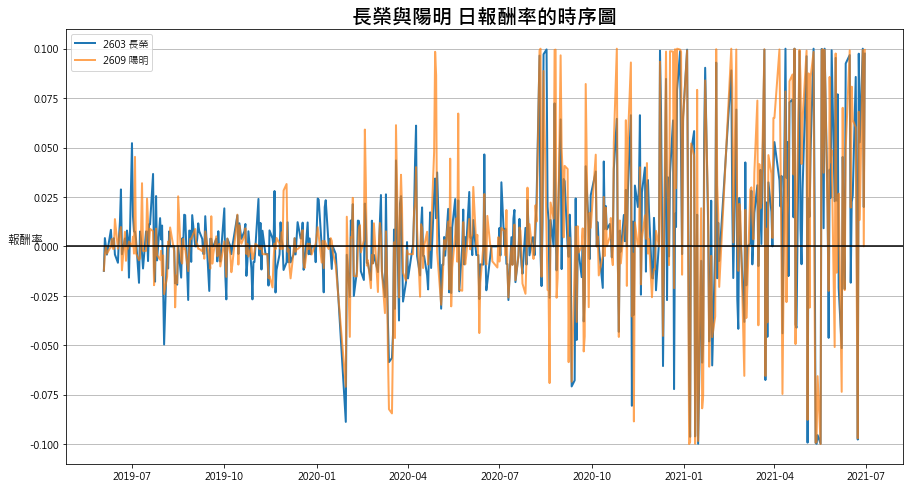

In [3]:
# 作長榮與陽明 日報酬率的時序圖
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot()

ax.plot(stock['2603 長榮'] ,linewidth=2, alpha=1)
ax.plot(stock['2609 陽明'] ,linewidth=2, alpha=0.7)
ax.axhline(0,color = 'black')
ax.set_title('長榮與陽明 日報酬率的時序圖' ,fontsize=20 ,fontweight='bold')
ax.legend(['2603 長榮','2609 陽明'],loc='best')
ax.set_ylabel('報酬率', fontsize=12,rotation=0)
ax.grid(axis='y')

In [4]:
# 價差
def CointegrationSpread(df,formStart,formEnd,tradeStart,tradeEnd):
    formX = df[(df.index >= formStart) & (df.index <= formEnd)]['2603 長榮']
    formY = df[(df.index >= formStart) & (df.index <= formEnd)]['2609 陽明']
    tradeX = df[(df.index >= tradeStart) & (df.index <= tradeEnd)]['2603 長榮']
    tradeY = df[(df.index >= tradeStart) & (df.index <= tradeEnd)]['2609 陽明']
    
    results = sm.OLS(formY,sm.add_constant(formX)).fit()
    spread = tradeY - results.params[0] - results.params[1] * tradeX
    return spread

Spread_2020_10_12 = CointegrationSpread(stock,'2019-06-01','2020-06-30','2020-10-01','2020-12-31')
Spread_2021_01_03 = CointegrationSpread(stock,'2020-01-01','2020-12-31','2021-01-01','2021-03-30')

In [5]:
# 對兩檔股價的價差序列做定態性檢定
adfSpread = ADF(Spread_2021_01_03, trend='n')
print(adfSpread.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -6.795
P-value                         0.000
Lags                                0
-------------------------------------

Trend: No Trend
Critical Values: -2.61 (1%), -1.95 (5%), -1.61 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Text(0, 0.5, 'Spread')

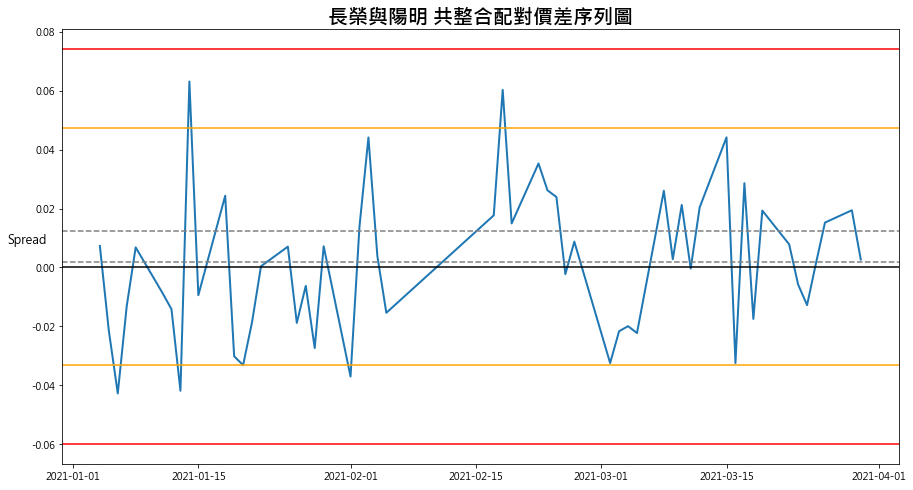

In [6]:
# 做共整合配對價差序列圖

fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot()
ax.plot(Spread_2021_01_03 ,linewidth=2, alpha=1)
ax.axhline(0,color = 'black')
ax.axhline(np.mean(Spread_2020_10_12) - 0.2 * np.std(Spread_2020_10_12),color = 'gray', linestyle='--')
ax.axhline(np.mean(Spread_2020_10_12) + 0.2 * np.std(Spread_2020_10_12),color = 'gray', linestyle='--')
ax.axhline(np.mean(Spread_2020_10_12) - 1.5 * np.std(Spread_2020_10_12),color = 'orange')
ax.axhline(np.mean(Spread_2020_10_12) + 1.5 * np.std(Spread_2020_10_12),color = 'orange')
ax.axhline(np.mean(Spread_2020_10_12) - 2.5 * np.std(Spread_2020_10_12),color = 'red')
ax.axhline(np.mean(Spread_2020_10_12) + 2.5 * np.std(Spread_2020_10_12),color = 'red')
ax.set_title('長榮與陽明 共整合配對價差序列圖' ,fontsize=20 ,fontweight='bold')
ax.set_ylabel('Spread', fontsize=12,rotation=0)

In [7]:
# 建立配對交易策略

mu = np.mean(Spread_2020_10_12)
sd = np.std(Spread_2020_10_12)

Spread_2021_01_03 = Spread_2021_01_03.to_frame()
Spread_2021_01_03.columns = ['價差']

Spread_2021_01_03['開倉平倉區間'] = \
    pd.cut(Spread_2021_01_03['價差'] ,
           (float('-inf') ,mu-2.5*sd ,mu-1.5*sd ,mu-0.2*sd ,
            mu+0.2*sd ,mu+1.5*sd ,mu+2.5*sd ,float('inf')) ,labels=False)-3

Spread_2021_01_03['交易訊號'] = \
    np.select([(Spread_2021_01_03['開倉平倉區間'].shift() == 1) &
               (Spread_2021_01_03['開倉平倉區間'] == 2),
               
               (Spread_2021_01_03['開倉平倉區間'].shift() == 1) &
               (Spread_2021_01_03['開倉平倉區間'] == 0),
               
               (Spread_2021_01_03['開倉平倉區間'].shift() == 2) &
               (Spread_2021_01_03['開倉平倉區間'] == 3),
               
               (Spread_2021_01_03['開倉平倉區間'].shift() == -1) &
               (Spread_2021_01_03['開倉平倉區間'] == -2),
               
               (Spread_2021_01_03['開倉平倉區間'].shift() == -1) &
               (Spread_2021_01_03['開倉平倉區間'] == 0),
               
               (Spread_2021_01_03['開倉平倉區間'].shift() == -2) &
               (Spread_2021_01_03['開倉平倉區間'] == -3)],
              
              [-2,2,3,1,-1,-3],default = 0)

position = [Spread_2021_01_03['交易訊號'][0]]
ns = len(Spread_2021_01_03['交易訊號'])

for i in range(1,ns):
    position.append(position[-1])
    if Spread_2021_01_03['交易訊號'][i] == 1:
        position[i] = 1
    elif Spread_2021_01_03['交易訊號'][i] == -2:
        position[i] = -1
    elif Spread_2021_01_03['交易訊號'][i] == -1 and position[i-1] == 1:
        position[i] = 0
    elif Spread_2021_01_03['交易訊號'][i] == -2 and position[i-1] == -1:
        position[i] = 0
    elif Spread_2021_01_03['交易訊號'][i] == 3:
        position[i] = 0
    elif Spread_2021_01_03['交易訊號'][i] == 3:
        position[i] = 0

Spread_2021_01_03['倉位情況'] = pd.Series(position,index=Spread_2021_01_03.index)
Spread_2021_01_03['倉位情況'] = Spread_2021_01_03['倉位情況'].shift() # 隔天開盤才進場

In [8]:
Spread_2021_01_03 = Spread_2021_01_03.join(stock)
Spread_2021_01_03['策略報酬率'] = \
    np.select([Spread_2021_01_03['倉位情況'] == 1,
               Spread_2021_01_03['倉位情況'] == 0,
               Spread_2021_01_03['倉位情況'] == -1],
              [Spread_2021_01_03['2609 陽明'] * -1 + Spread_2021_01_03['2603 長榮'] * 1,
               0,
               Spread_2021_01_03['2609 陽明'] * 1 + Spread_2021_01_03['2603 長榮'] * -1], default=np.nan)

Spread_2021_01_03['累積報酬率'] = (Spread_2021_01_03['策略報酬率'] + 1).cumprod() -1
Spread_2021_01_03.head(10)

,價差,開倉平倉區間,交易訊號,倉位情況,2603 長榮,2609 陽明,策略報酬率,累積報酬率
日期,,,,,,,,
2021-01-04 00:00:00+00:00,0.007319,0,0,NaN,0.099509,0.099145,NaN,NaN
2021-01-05 00:00:00+00:00,-0.021419,-1,0,0.0,0.016760,-0.004666,0.000000,0.000000
2021-01-06 00:00:00+00:00,-0.042727,-2,1,0.0,-0.064835,-0.100000,0.000000,0.000000
2021-01-07 00:00:00+00:00,-0.013087,-1,0,1.0,-0.096357,-0.098958,0.002601,0.002601
2021-01-08 00:00:00+00:00,0.006824,0,-1,1.0,0.048114,0.052023,-0.003909,-0.001318
2021-01-11 00:00:00+00:00,-0.008664,-1,0,0.0,0.058313,0.045788,0.000000,-0.001318
2021-01-12 00:00:00+00:00,-0.014159,-1,0,0.0,-0.096131,-0.099825,0.000000,-0.001318
2021-01-13 00:00:00+00:00,-0.041809,-2,1,0.0,-0.028534,-0.066148,0.000000,-0.001318
2021-01-14 00:00:00+00:00,0.063084,2,0,1.0,0.016021,0.079167,-0.063146,-0.064381


Text(0, 0.5, 'Return %')

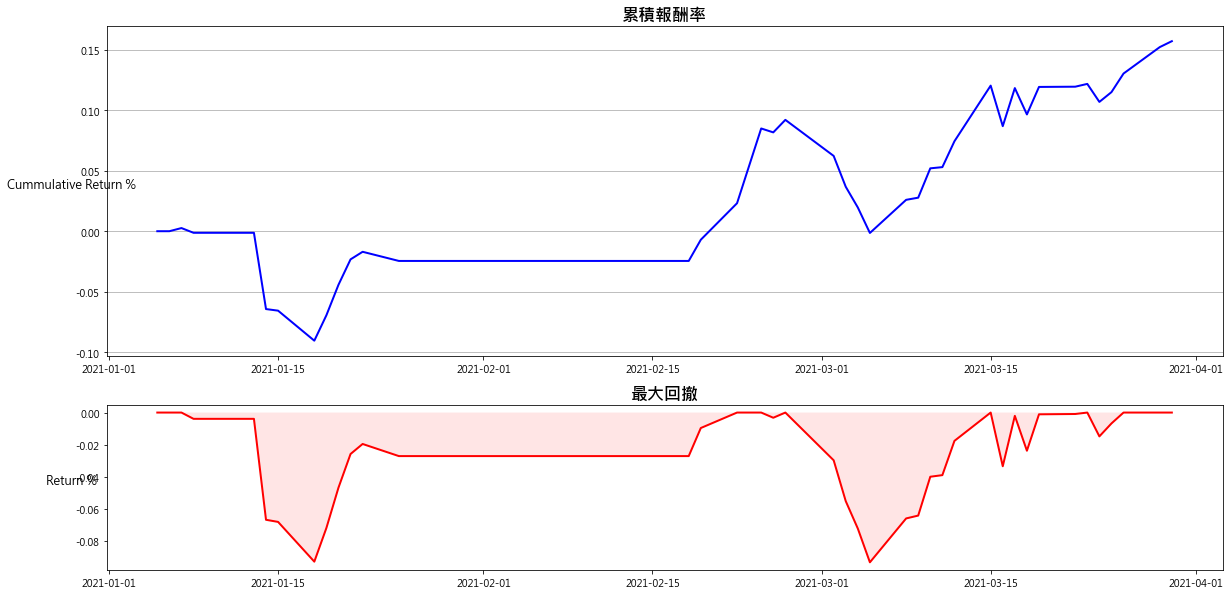

In [9]:
# 看累積報酬率與最大回撤圖

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(20,10), gridspec_kw={'height_ratios': [2,1]})
   
ax1.set_title('累積報酬率', fontsize=17, fontweight='bold')
ax1.plot(Spread_2021_01_03['累積報酬率'], linewidth=2, alpha=1,color='b')
ax1.set_ylabel('Cummulative Return %', fontsize=12,rotation=0)
ax1.grid(axis='y')

ax2.plot(Spread_2021_01_03['累積報酬率'] - Spread_2021_01_03['累積報酬率'].cummax(),linewidth=2, alpha=1, color='r')
ax2.fill_between(Spread_2021_01_03.index, 0 ,
                 Spread_2021_01_03['累積報酬率'] - Spread_2021_01_03['累積報酬率'].cummax(),
                 facecolor='r', alpha=0.1)
ax2.set_title("最大回撤", fontsize=17, fontweight='bold')
ax2.set_ylabel('Return %', fontsize=12,rotation=0)
